```
This software is a part of GPU Ocean.

Copyright (C) 2018  SINTEF Digital

This notebook creates figures that illustrate how the model error
is created.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Model errors

This notebook is used to make figures that illustrates how the small scale perturbations is generated.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic

from SWESimulators import OceanStateNoise

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
imgdir = 'model_errors'
filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir, exist_ok=True)
print("Saving images to " + imgdir)

Saving images to model_errors


In [4]:
eta_cmap = 'BrBG'
huv_cmap = 'RdBu'

def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=eta_cmap)
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower', cmap=eta_cmap)
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,4), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=eta_cmap)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', cmap=eta_cmap)
    axs[0].set_title("$\delta \eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=huv_cmap)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', cmap=huv_cmap)
    axs[1].set_title("$\delta hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', cmap=huv_cmap)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', cmap=huv_cmap)
    axs[2].set_title("$\delta hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

def imshow6(eta1, hu1, hv1, eta2, hu2, hv2, interpolation="None", title=None):
    fig, axs = plt.subplots(3,3, figsize=(12,13))
    
    range_eta = max(np.max(np.abs(eta1)), np.max(np.abs(eta2)))
    range_huv = max(np.max(np.abs(hu1)), np.max(np.abs(hu2)), np.max(np.abs(hv1)), np.max(np.abs(hv2)))
    
    eta_im = axs[0,0].imshow(eta1, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[0,0].set_title("eta 1")
    plt.colorbar(eta_im, ax=axs[0,0])
    
    hu_im = axs[0,1].imshow(hu1, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[0,1].set_title("hu 1")
    plt.colorbar(hu_im, ax=axs[0,1])

    hv_im = axs[0,2].imshow(hv1, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[0,2].set_title("hv 1")
    plt.colorbar(hv_im, ax=axs[0,2])

    
    eta_im2 = axs[1,0].imshow(eta2, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[1,0].set_title("eta 2")
    plt.colorbar(eta_im, ax=axs[1,0])
    
    hu_im2 = axs[1,1].imshow(hu2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1,1].set_title("hu 2")
    plt.colorbar(hu_im, ax=axs[1,1])

    hv_im2 = axs[1,2].imshow(hv2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[1,2].set_title("hv 2")
    plt.colorbar(hv_im, ax=axs[1,2])
    
    
    eta_im3 = axs[2,0].imshow(eta1 - eta2, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta, cmap=eta_cmap)
    axs[2,0].set_title("diff eta")
    plt.colorbar(eta_im, ax=axs[2,0])
    
    hu_im3 = axs[2,1].imshow(hu1 - hu2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2,1].set_title("diff hu")
    plt.colorbar(hu_im, ax=axs[2,1])

    hv_im3 = axs[2,2].imshow(hv1 - hv2, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv, cmap=huv_cmap)
    axs[2,2].set_title("diff hv")
    plt.colorbar(hv_im, ax=axs[2,2])

    if title is not None:
        plt.suptitle(title, fontsize=18)
    plt.tight_layout()   

# Testing the new class


random_vals.shape (30, 30)
coarse_vals.shape (34, 34)


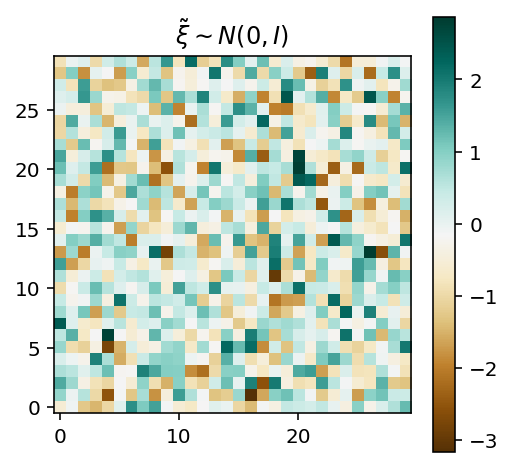

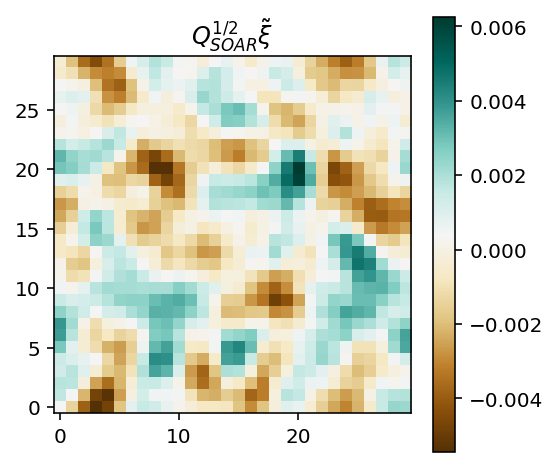

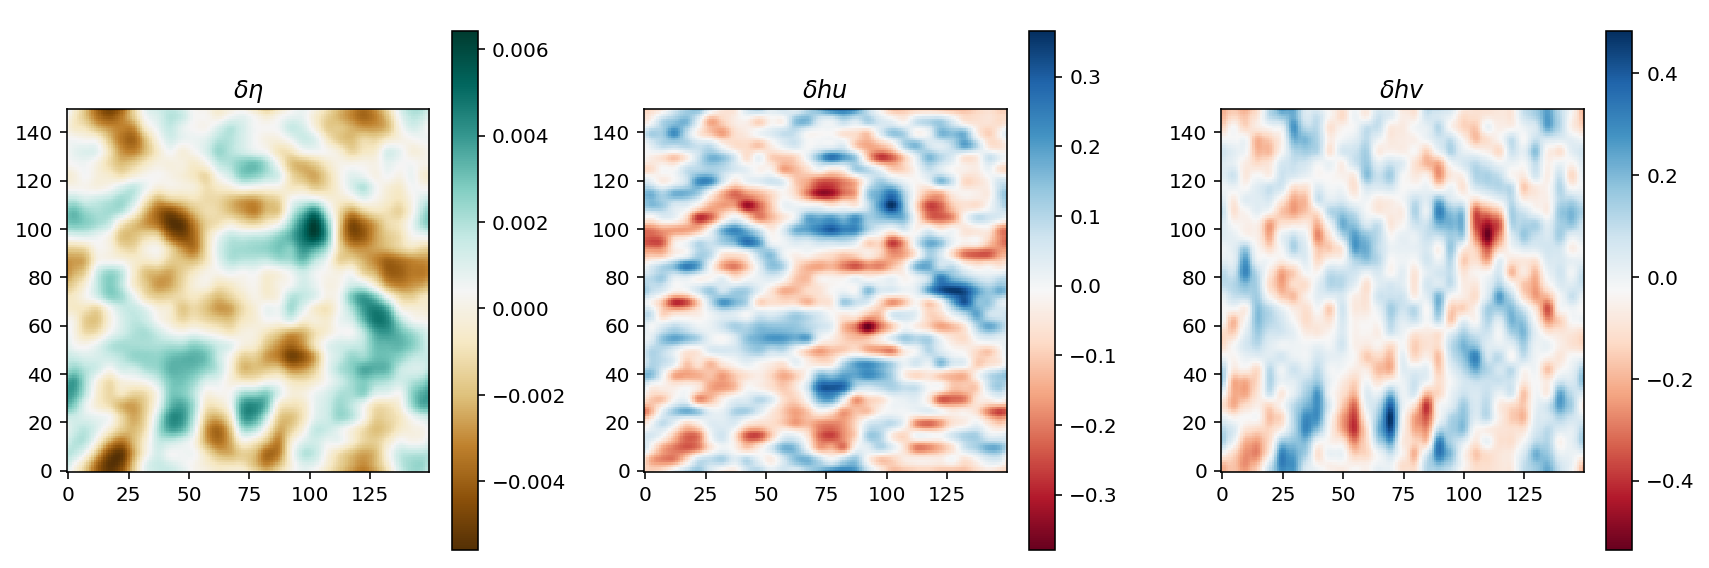

In [5]:
if 'newnoise' in globals():
    newnoise.cleanUp()
if 'sim' in globals():
    sim.cleanUp()
    
reload(OceanStateNoise)
nx, ny = 150, 150
dx, dy = 100.0, 100.0
interpolation_factor = 5

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx, "ny": ny,
    "dx": dx, "dy": dy,
    "dt": 0.5,
    "g": 9.81,
    "f": 0.002,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 5,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}
ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth

sim = CDKLM16.CDKLM16(**sim_args)


noise_args = {
    "gpu_ctx": gpu_ctx,
    "gpu_stream": sim.gpu_stream,
    "nx": nx, "ny": ny,
    "dx": dx, "dy": dy,
    "boundaryConditions": Common.BoundaryConditions(2,2,2,2),
    "staggered": False,
    "interpolation_factor": sim_args["small_scale_perturbation_interpolation_factor"]
}

newnoise = OceanStateNoise.OceanStateNoise(**noise_args)
newnoise.perturbSim(sim)

figsize = 4
figsize1 = (figsize, figsize)
figsize3 = (3*figsize, figsize)

save = False
#save=True

random_vals = newnoise.getRandomNumbers()
imshow(random_vals, title=r'$\tilde{\xi} \sim N(0,I)$', figsize=figsize1, interior=False)
if save: plt.savefig(filename_prefix + "_random_vals.pdf", format='pdf')

coarse_vals = newnoise.getCoarseBuffer()
imshow(coarse_vals, title=r'$Q_{SOAR}^{1/2} \tilde{\xi}$', figsize=figsize1, interior=True)
if save: plt.savefig(filename_prefix + "_coarse_vals.pdf", format='pdf')

d_eta, d_hu, d_hv = sim.download(interior_domain_only=False)
imshow3(d_eta, d_hu, d_hv, title=" ", figsize=figsize3, interior=True)
if save: plt.savefig(filename_prefix + "_model_error.pdf", format='pdf')

# Save data files
if save:
    np.save(filename_prefix + "_random_vals", random_vals)
    np.save(filename_prefix + "_coarse_vals", coarse_vals)
    np.save(filename_prefix + "_delta_eta", d_eta)
    np.save(filename_prefix + "_delta_hu", d_hu)
    np.save(filename_prefix + "_delta_hv", d_hv)

print("random_vals.shape", random_vals.shape)
print("coarse_vals.shape", coarse_vals.shape)


In [6]:
print(filename_prefix)
print(save)

model_errors/2019_08_12-20_40_27
True
